In [533]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import fft


Variable initialization

In [534]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion


C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [535]:
for i in range(M):
    a = np.zeros(M)
    a[i] = 1
    DCT[:, i] = fft.idct(a, norm='ortho')


Generating the 1-D canonical basis

In [536]:
for i in range(M):
    pass
#    C[:, i] = a
C = np.eye(M, M)

Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

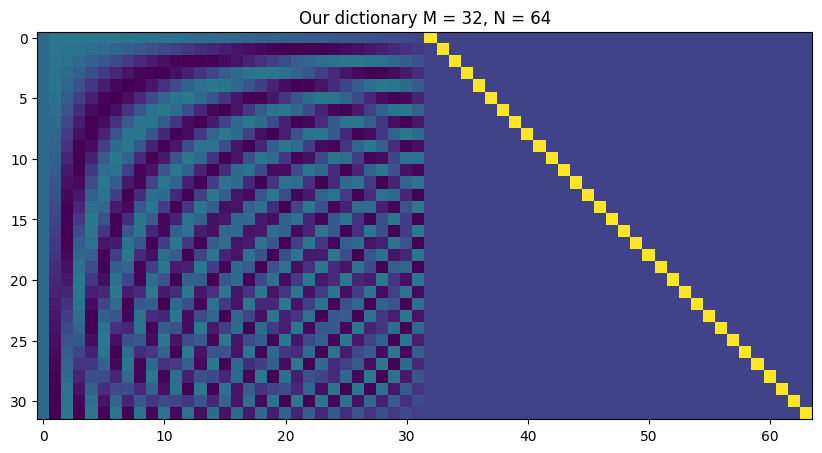

In [537]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $D$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to $\mathbf{s}$ that is sparse w.r.t. $C$. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [538]:
L = 4
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $DCT$ (make sure the nonzero coefficients are sufficiently large)

In [539]:
# Sparsity
K = 5

In [540]:
x0 = np.zeros(N)
nonzeros_coeffs = np.random.choice(M, K)
x0[nonzeros_coeffs] = np.random.random(K)

x0_non_spiked = x0.copy()

Choose spike location

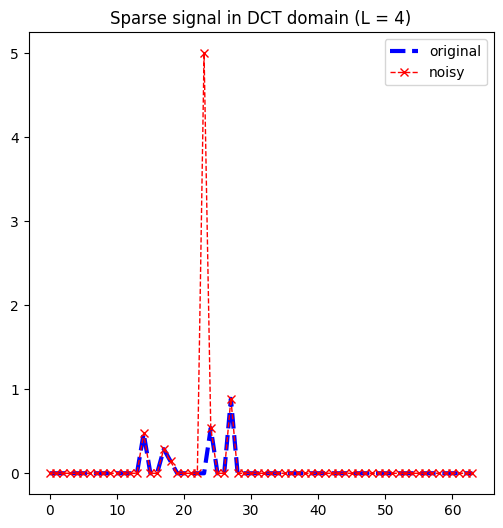

In [541]:
LN_WDT = 2
MRK_SZ = 10

spikeLocation = 23
x0[spikeLocation] = 5

plt.figure(figsize=(6, 6))
plt.plot(x0_non_spiked, 'b--', linewidth=LN_WDT+1)
plt.plot(x0, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Synthetize the corresponding signal in the signal domain and add noise


In [542]:
s0 = D @ x0
s = s0 + sigma_noise

Plot the sparse signal

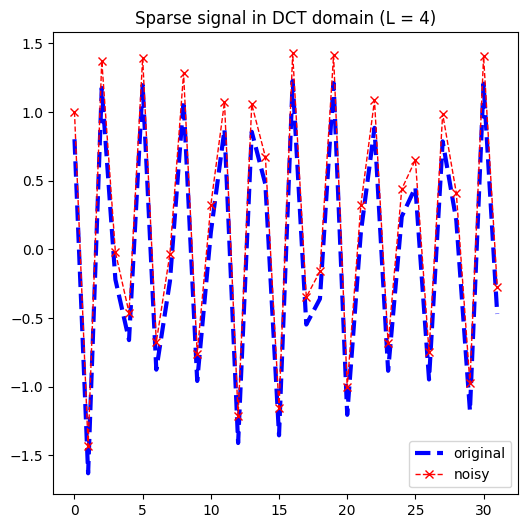

In [543]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Orthogonal Matching Pursuit
---------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [544]:
x_OMP = np.zeros(N)

# residual
r = s

# support set
omega = []

MINIMUM_NORM_RES = 0.1

OMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [545]:
while np.count_nonzero(x_OMP) <= L:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    eps = np.zeros(N)
    for j in range(D.shape[1]):
        dj = D[:, j]
        eps[j] = np.linalg.norm(r) - np.dot(r.T, dj)**2 / np.linalg.norm(dj)

    # Find jStar using argmin(eps)
    jStar = np.argmin(eps)

    # Update omega set with the index of the column found by argmax
    omega.append(jStar)

    # Create D omega
    D_omega = D[:, omega]

    # u_omega, _, _, _ = np.linalg.lstsq(np.dot(D_omega.T, D_omega), np.dot(D.T, s))
    u_omega, _, _, _ = np.linalg.lstsq(D_omega, s, rcond=None)

    x_OMP = np.zeros(N)
    x_OMP[omega] = u_omega

    # update the residual
    r = s - D @ x_OMP 

SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [546]:
s_hat_OMP = D @ x_OMP

Show the result

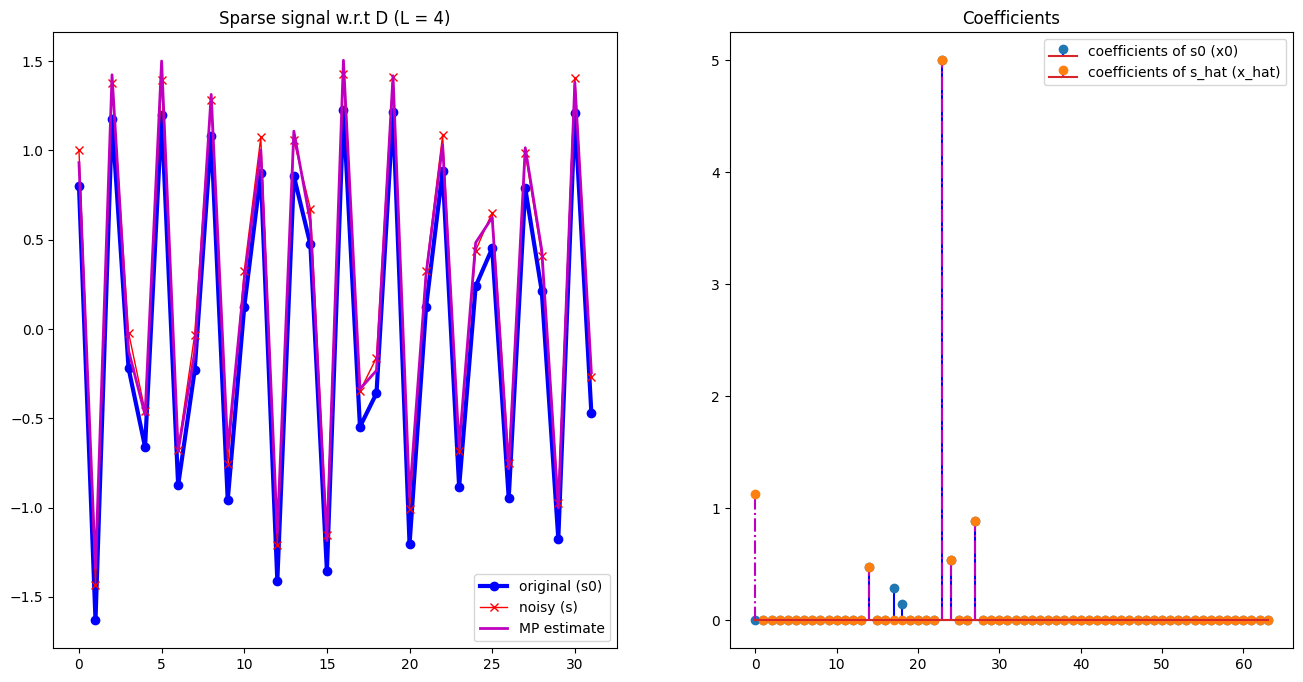

In [547]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_OMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_OMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

Least Squares Orthogonal Matching Pursuit
-----------------------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [548]:
x_LSOMP = np.zeros(N)

# residual
r = s.copy()

# support set
omega = []

MINIMUM_NORM_RES = 1e-6

LSOMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

The difference between OMP and LSOMP is that when we perform the sweep step we calculate not just the distance but the l2 norm of the distance.

In [549]:
while np.count_nonzero(x_LSOMP) <= L:
    # SWEEP STEP: find the best column by solving the LS problem
    if len(omega) == 0:
        # at the first iteration perform the usual sweep step
        # initialize epsilon vector
        eps = np.zeros(N)

        for j in range(N):
            # pick j-th column of Dictionary D
            dj = D[:, j]

            # compute the epsilon distance of the residual and the j-th column of D
            eps[j] = np.linalg.norm(r) - (np.dot(r.T, dj) ** 2) / np.linalg.norm(dj)

        # find the closest atom of D to the residual
        jStar = np.argmin(eps)

        # append closest atom's index to omega
        omega.append(jStar)

        # create omega D
        D_omega = D[:, omega]

        # Calculate x which is now u_omega w.r.t s
        u_omega, _, _, _ = np.linalg.lstsq(D_omega, s, rcond=None)

        # reset x and set it with new omega values
        x_LSOMP[omega] = u_omega
    else:
        # perform the sweep step by solving the LS problem
        eps = np.zeros(N)

        for j in range(N):
            # if j is already in omega, skip
            if j in omega:
                print(f"Skipping {j}")
                continue

            # create new D by concatenating D_j to D_omega
            D_dj = np.column_stack((D_omega, D[:, j]))
            
            # compute the least square solution of u_j and z_j to find new j in omega
            uz_j, _, _, _ = np.linalg.lstsq(
                D_dj, s, rcond=None
            )

            # take apart uz_j into u_j and z_j (u_j here is a vector, z_j is a scalar)
            # [D_omega, d_j].T @ [u_omega, z_j]
            u_j, z_j = uz_j[:-1], uz_j[-1]

            # append the residual to the epsilon
            residual = s - D_dj @ uz_j
            eps_j = np.linalg.norm(residual)
            eps[j] = eps_j

        # find smallest epsilon
        # print(f"Looking for min in {eps}")
        jStar = np.argmin(eps)

        # do not get in to an infinite loop
        if jStar in omega:
            break

        # append jStar to omega
        omega.append(jStar)

        # update omega D
        D_omega = D[:, omega]

        # compute u_omega
        u_omega, _, _, _ = np.linalg.lstsq(D_omega, s, rcond=None)

        # update x
        x_LSOMP[omega] = u_omega
        print(np.count_nonzero(x_LSOMP))

    # update the residual
    r = s - D @ x_LSOMP

    if np.linalg.norm(r) < MINIMUM_NORM_RES:
        break

Skipping 23


SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [550]:
s_hat_LSOMP = D @ x_LSOMP

Show the result

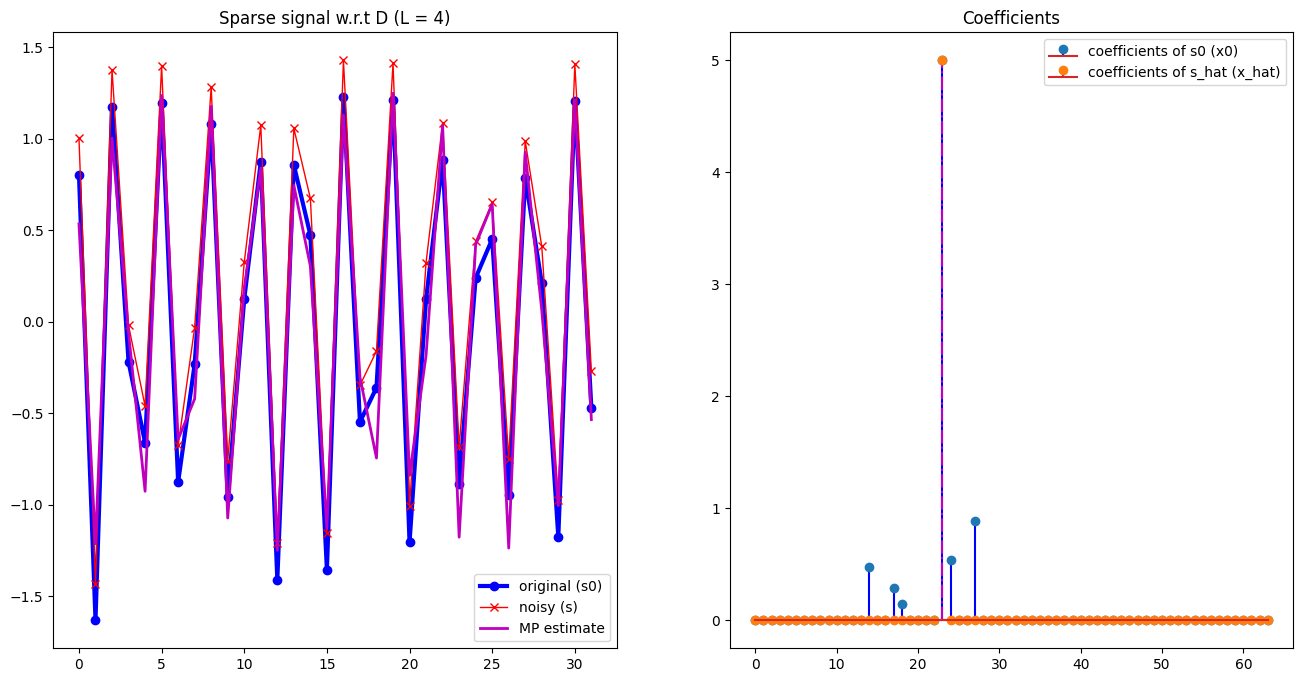

In [551]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_LSOMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_LSOMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])